In [899]:
import numpy as np
from matplotlib import pyplot as plt
import xraydb
from scipy import stats
from scipy.optimize import curve_fit

# Mosley's Law

In [900]:
# Z vs. Energy data for K-alpha and K-beta shells

Z = np.array([29, 37, 42, 47, 56, 65])
E_ka = np.array([8.17, 13.51, 17.56, 22.09, 31.86, 44.63])
E_kb = np.array([8.92, 15.14, 19.92, 24.89, 35.99, 50.58])
lhm_ka = np.array([7.71, 13.14, 17.23, 21.60, 31.35, 43.79])
rhm_ka = np.array([8.73, 13.93, 18.02, 22.50, 32.28, 45.23])
lhm_kb = np.array([8.42, 14.68, 19.41, 24.44, 35.62, 50.06])
rhm_kb = np.array([9.43, 15.60, 20.30, 25.39, 36.60, 51.27])
fwhm_ka = rhm_ka - lhm_ka
fwhm_kb = rhm_kb - lhm_kb

In [901]:
# Reading .Spe files
z_to_filename = {
    29: "COPPER",
    37: "RUBIDIUM",
    42: "MOLYBDENUM",
    47: "AG_Mosley",
    56: "BARIUM",
    65: "TERBIUM",
}

def read_spe(filename):
    if type(filename) != str:
        filename = z_to_filename[int(filename)]

    with open("data/" + filename + ".Spe", "r") as f:
        lines = f.readlines()
        bins = np.array(list(map(lambda x: float(x.strip()), lines[12:-16])))

    for i in range(len(lines) - 1, -1, -1):
        if lines[i].startswith("$ENER_FIT"):
            bin_width = float(lines[i+1].strip().split(" ")[-1])
            break

    return bins, bin_width

def fwhm_to_total_counts(filename, left_half, right_half):
    bins, bin_width = read_spe(filename)

    left_half = int(left_half / bin_width)
    right_half = int(right_half / bin_width)
    between_fwhm = np.sum(bins[left_half:right_half])

    return between_fwhm / 0.3289

def fwhm_to_uncert(fwhm, N):
    return fwhm / 2.355 / np.sqrt(N)

[ 0.10485751 -0.20669026] [[ 1.44658997e-03 -6.34171403e-02]
 [-6.34171403e-02  2.92221715e+00]]
0.005178679510276831 0.005121572720626423


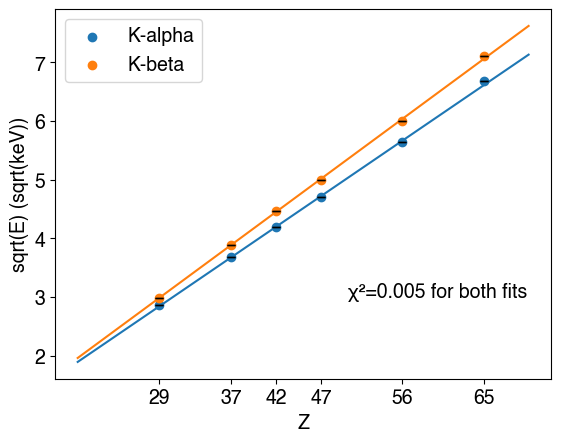

In [902]:
# Curve fit to find slope and intercept of Z vs. sqrt(E) line

def line(x, m, b):
    return m*x + b

popt_ka, pcov_ka = curve_fit(f=line, xdata=Z, ydata=np.sqrt(E_ka), sigma=fwhm_ka, p0=[1,0.3], absolute_sigma=True)
popt_kb, pcov_kb = curve_fit(f=line, xdata=Z, ydata=np.sqrt(E_kb), sigma=fwhm_kb, p0=[1,0.3], absolute_sigma=True)
sig_ka = np.sqrt(np.diag(pcov_ka))
uncert_kb = np.sqrt(np.diag(pcov_kb))
print(popt_ka, pcov_ka)


# Plot the best fit vs. the above plot
x = np.linspace(20, 70, 500)
plt.scatter(Z, np.sqrt(E_ka))
plt.scatter(Z, np.sqrt(E_kb))

chi2_ka = np.sum((np.sqrt(E_ka) - line(Z, *popt_ka))**2/fwhm_ka)
chi2_kb = np.sum((np.sqrt(E_kb) - line(Z, *popt_kb))**2/fwhm_kb)
print(chi2_ka, chi2_kb)

plt.plot(x, line(x, *popt_ka))
plt.plot(x, line(x, *popt_kb))

uncert_ka = [fwhm_to_uncert(fwhm_ka[i], fwhm_to_total_counts(z, lhm_ka[i], rhm_ka[i])) for i, z in enumerate(Z)]
uncert_kb = [fwhm_to_uncert(fwhm_kb[i], fwhm_to_total_counts(z, lhm_kb[i], rhm_kb[i])) for i, z in enumerate(Z)]
plt.errorbar(Z, np.sqrt(E_ka), yerr=uncert_ka, fmt='none', color='black', capsize=3)
plt.errorbar(Z, np.sqrt(E_kb), yerr=uncert_kb, fmt='none', color='black', capsize=3)

plt.legend(['K-alpha', 'K-beta'])
plt.annotate("\u03C7\u00b2=" + str(round(chi2_ka, 3)) + " for both fits", (50.0, 3.0), color="black")
plt.rcParams.update({'font.size': 14, 'font.family': 'Helvetica'})
plt.xlabel("Z")
plt.ylabel("sqrt(E) (sqrt(keV))")
plt.xticks(Z)#, ['Cu', 'Ru', 'Mo', 'Ag', 'Ba', 'Tb'])
plt.savefig('mosley.pdf', bbox_inches='tight', pad_inches=0.01)
plt.show()

In [903]:
# The values to be used in Mosley's Law

print(f"C_ka = {popt_ka[0]} pm {uncert_ka[0]}")
print(f"C_kb = {popt_kb[0]} pm {uncert_kb[0]}")

uncert_sig_ka = np.sqrt((uncert_ka[1] / popt_ka[1])**2 + (uncert_ka[0] / popt_ka[0])**2) * popt_ka[1] / -popt_ka[0]
uncert_sig_kb = np.sqrt((uncert_kb[1] / popt_kb[1])**2 + (uncert_kb[0] / popt_kb[0])**2) * popt_kb[1] / -popt_kb[0]
print(f"Sigma_ka = {popt_ka[1] / -popt_ka[0]} pm {uncert_sig_ka}")
print(f"Sigma_kb = {popt_kb[1] / -popt_kb[0]} pm {uncert_sig_kb}")

C_ka = 0.1048575052273781 pm 0.0011686188575387882
C_kb = 0.1133150975778887 pm 0.0014603200226786768
Sigma_ka = 1.9711537411059037 pm 0.0225203444383806
Sigma_kb = 2.7235338206927695 pm 0.03647451007280931


# Escape Peak Ratios

In [904]:
# Data on counts of escape peaks - not including Cu, because not escape peaks.

counts = {
    "Z"           : np.array([37, 42, 47, 56, 65]),
    "alpha_escape": np.array([598, 1026, 662, 298, 179]),
    "beta_escape" : np.array([411, 264, 170, 80, 179]),
    "alpha"       : np.array([10004, 10006, 10023, 10010, 10420]),
    "beta"        : np.array([2609, 2542, 2593, 2413, 3124])
}
left_half = {
    "alpha_escape": np.array([3.95, 7.24, 11.7, 21.46, 33.72]),
    "beta_escape": np.array([4.64, 9.47, 14.64, 25.64, 33.72]),
    "alpha": np.array([13.14, 17.23, 21.6, 31.35, 43.79]),
    "beta": np.array([14.68, 19.41, 24.44, 35.62, 50.06]),
}
right_half = {
    "alpha_escape": np.array([4.27, 8.08, 12.65, 22.52, 35.25]),
    "beta_escape": np.array([5.67, 10.31, 15.45, 26.84, 35.25]),
    "alpha": np.array([13.93, 18.02, 22.5, 32.28, 45.23]),
    "beta": np.array([15.60, 20.3, 25.39, 36.6, 51.72]),
}
fwhm = {
    "alpha_escape": right_half["alpha_escape"] - left_half["alpha_escape"],
    "beta_escape": right_half["beta_escape"] - left_half["beta_escape"],
    "alpha": right_half["alpha"] - left_half["alpha"],
    "beta": right_half["beta"] - left_half["beta"],
}

Z = counts["Z"]

total_counts = {
    "alpha_escape": np.array([fwhm_to_total_counts(z, left_half["alpha_escape"][i], right_half["alpha_escape"][i]) for i, z in enumerate(Z)]),
    "beta_escape": np.array([fwhm_to_total_counts(z, left_half["beta_escape"][i], right_half["beta_escape"][i]) for i, z in enumerate(Z)]),
    "alpha": np.array([fwhm_to_total_counts(z, left_half["alpha"][i], right_half["alpha"][i]) for i, z in enumerate(Z)]),
    "beta": np.array([fwhm_to_total_counts(z, left_half["beta"][i], right_half["beta"][i]) for i, z in enumerate(Z)]),
}

uncertainty = {
    "alpha_escape": np.array([fwhm_to_uncert(fwhm["alpha_escape"][i], total_counts["alpha_escape"][i]) for i in range(len(Z))]),
    "beta_escape": np.array([fwhm_to_uncert(fwhm["beta_escape"][i], total_counts["beta_escape"][i]) for i in range(len(Z))]),
    "alpha": np.array([fwhm_to_uncert(fwhm["alpha"][i], total_counts["alpha"][i]) for i in range(len(Z))]),
    "beta": np.array([fwhm_to_uncert(fwhm["beta"][i], total_counts["beta"][i]) for i in range(len(Z))]),
}

In [905]:
ratio_alpha = counts["alpha_escape"] / counts["alpha"]
uncertainty_alpha = np.sqrt(uncertainty["alpha_escape"]**2 + uncertainty["alpha"]**2)
ratio_beta = counts["beta_escape"] / counts["beta"]
uncertainty_beta = np.sqrt(uncertainty["beta_escape"]**2 + uncertainty["beta"]**2)
ratio_nice = np.concatenate((ratio_beta[0:1], ratio_alpha[1:]))
uncertainty_nice = np.concatenate((uncertainty_beta[0:1], uncertainty_alpha[1:]))

## Monte Carlo Model

In [906]:
# The xraydb mu_elam values seem really poor, so going to interpolate between the NIST values.

NIST = {
    "E": np.array([8., 10., 11.103, 15., 20., 30., 40., 50., 60., 80., 100., 150., 200.]),
    "mu": np.array([68.9, 37.42, 198.1, 91.52, 42.22, 13.85, 6.207, 3.335, 2.023, 0.9501, 0.555, 0.2491, 0.1661]),
    "mu_en": np.array([66.6, 35.64, 115.7, 62.56, 31.78, 11.26, 5.152, 2.759, 1.642, 0.7184, 0.3803, 0.1288, 0.06865])
}

def mu(E, idx="mu_en"):
    val = np.interp(E, NIST["E"], NIST[idx])
    if val == NIST[idx][-1]:
        raise ValueError("Energy too high: ", E)
    elif val == NIST[idx][0]:
        raise ValueError("Energy too low: ", E)
    
    return val

In [907]:
D = 2.18 # cm
r = 5.11 / 2.0 # cm
rho = 5.323 # g/cm^3

E_Ge_ka = 9886.42 # eV
E_Ge_kb = 10982.1 # eV

# mu_E1 = 14.0 * rho  # meters # MAKE SURE TO INTERPOLATE: goes as 1/E^3
# mu_E2 = 37.0 * rho # meters
# prob_auger = 0.465 # 1.0 - 0.583 # https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/epdf/10.1002/xrs.1300040211

def rand_solid_angle(samples):
    u = np.random.uniform(size=samples)
    v = np.random.uniform(size=samples)
    theta = 2 * np.pi * u
    phi = np.arccos(2*v - 1)
    return theta, phi

# for E in E_ka[1:]:
#     print("-----------------")
#     print("E=", E)
#     print(xraydb.mu_elam("Ge", E))
#     print(mu(E) * rho)

def simulate_ratio(E, samples=1000000):
    """Returns escape peak ratio, given E in eV"""

    # mu_1 = xraydb.mu_elam("Ge", E)
    # mu_2 = xraydb.mu_elam("Ge", E_Ge_ka)
    mu_1 = mu(E / 1000.0) * rho
    mu_2 = mu(E_Ge_ka / 1000.0) * rho
    # print("mu_1=", mu_1)
    # print("mu_2=", mu_2)


    d_1 = np.random.exponential(scale=1.0/mu_1, size=samples)
    
    d_1 = d_1[np.where(d_1 < D)]
    passed_through = samples - d_1.size
    
    # Auger Effect
    fluor_yield = o = xraydb.fluor_yield("Ge", "K", "Ka", E)[0]
    d_1 = np.random.choice(d_1, size=int(fluor_yield * d_1.size), replace=False)
    
    # theta = 2 * np.pi * np.random.uniform(size=d_1.size)
    theta, phi = rand_solid_angle(d_1.size) # Chunks of same cos theta should have same number of samples
    d_2 = np.random.exponential(scale=1.0/mu_2, size=d_1.size)

    print(np.mean(d_1), np.mean(d_2))
    
    num_escaped = np.where((d_1 + d_2*np.cos(theta) > D) | (d_1 + d_2*np.cos(theta) < 0.0) | (d_2*np.sin(theta) > r))[0].size
    print("radial escape: ", np.where(d_2*np.sin(theta) > r)[0].size)
    print("right escape: ", np.where(d_1 + d_2*np.cos(theta) > D)[0].size)
    print("left escape: ", np.where(d_1 + d_2*np.cos(theta) < 0.0)[0].size)

    print(f"Passed through: {100.0 * passed_through / samples}%")
    print(f"Escaped given no pass through: {100 * num_escaped / (samples - passed_through)}%")
    
    return num_escaped / (samples - passed_through - num_escaped)

def simplified_simulate_ratio(E, samples=1000000):
    mu_1 = mu(E / 1000.0) * rho
    p_kb = 0.15 / 1.15
    p_ka = 1.0 - p_kb
    mu_2 = mu(E_Ge_ka / 1000.0) * rho
    mu_2_ka = mu(E_Ge_ka / 1000.0) * rho
    mu_2_kb = mu(E_Ge_kb / 1000.0) * rho

    d_1 = np.random.exponential(scale=1.0/mu_1, size=samples)
    
    # Auger Effect
    fluor_yield = o = xraydb.fluor_yield("Ge", "K", "Ka", E)[0]
    d_1 = np.random.choice(d_1, size=int(fluor_yield * d_1.size), replace=False)
    
    theta, phi = rand_solid_angle(d_1.size)

    d_2_ka = np.random.exponential(scale=1.0/mu_2_ka, size=int(d_1.size * p_ka + 1))
    d_2_kb = np.random.exponential(scale=1.0/mu_2_kb, size=int(d_1.size * p_kb))
    d_2 = np.concatenate([d_2_ka, d_2_kb])
    # d_2 = np.random.exponential(scale=1.0/mu_2, size=d_1.size)
    
    num_escaped = np.where(d_1 + d_2*np.cos(theta) < 0.0)[0].size
    
    return num_escaped / (samples - num_escaped)

def sim_with_uncertainty(E, samples=1000000, iterations=10):
    ratios = np.array([simplified_simulate_ratio(E, samples=int(samples / iterations)) for _ in range(iterations)])
    return np.mean(ratios), np.std(ratios) / np.sqrt(iterations)

Chi2:  0.004999378886469251


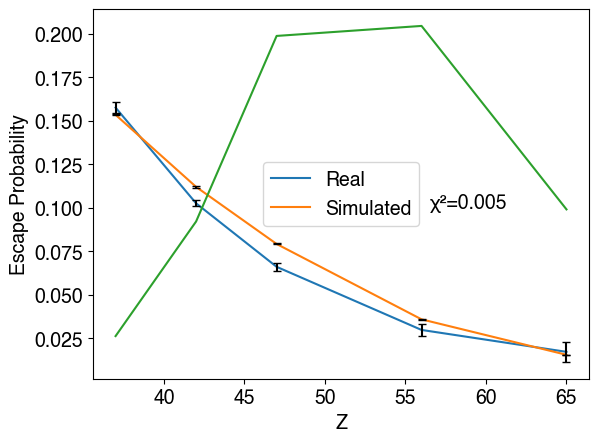

In [908]:
# Plot for nice ratios
def plot(energies, observed_ratios, observed_uncertainties):
    r_sig = np.array([sim_with_uncertainty(E) for E in energies])
    sim_ratios = r_sig[:, 0]
    sim_uncertainty = r_sig[:, 1]

    plt.plot(Z, observed_ratios)
    plt.plot(Z, sim_ratios)
    # plt.plot(Z, np.abs(observed_ratios - sim_ratios) / observed_ratios)

    # Error bars
    plt.errorbar(Z, observed_ratios, yerr=observed_uncertainties, fmt="none", color="black", capsize=3)
    plt.errorbar(Z, sim_ratios, yerr=sim_uncertainty, fmt="none", color="black", capsize=3)

    # Calculate chi2
    chi2 = np.sum((observed_ratios - sim_ratios)**2/observed_ratios)
    print("Chi2: ", chi2)

    plt.legend(["Real", "Simulated"])
    plt.xlabel("Z")
    plt.ylabel("Escape Probability")
    plt.annotate("\u03C7\u00b2=" + str(round(chi2, 3)), (56.5, 0.1), color="black")
    plt.rcParams.update({'font.size': 14, 'font.family': 'Helvetica'})
    plt.savefig('ratio.pdf', bbox_inches='tight', pad_inches=0.01)
    plt.show()

plot(E_ka[1:] * 1000.0, ratio_nice, uncertainty_nice)

Chi2:  0.15343843758442394


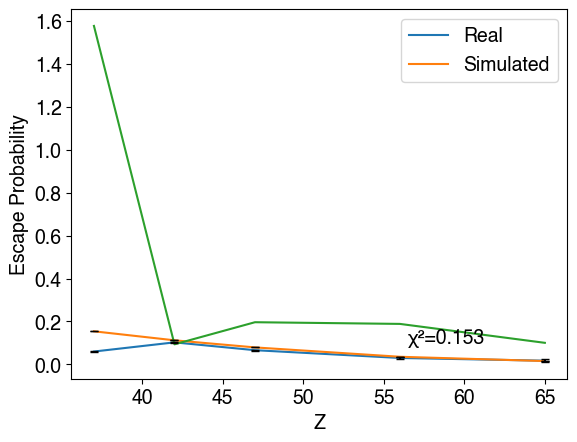

In [909]:
# K_a only plot
plot(E_ka[1:] * 1000.0, ratio_alpha, uncertainty_alpha)

Chi2:  0.04551341876207487


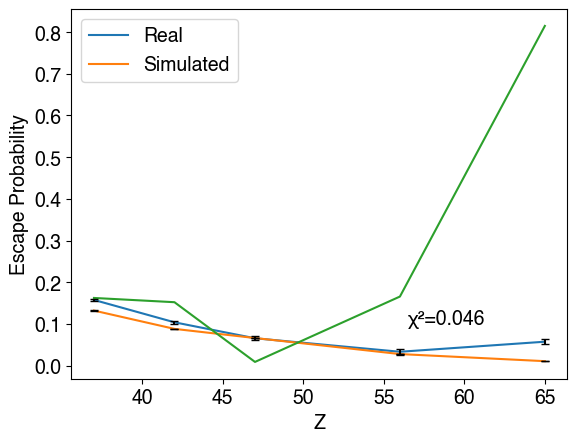

In [910]:
# Separate plot for K_beta only
plot(E_kb[1:] * 1000.0, ratio_beta, uncertainty_beta)